# Statistical Comparison

In [2]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mc_dir = Path.cwd().parent
if str(mc_dir) not in sys.path:
    sys.path.insert(0, str(mc_dir))

import MC.TM_monte_carlo as tm_mc
import MC.GS_monte_carlo as gs_mc

# seed values for reproducibility set to 1

In [3]:
tm_chain_lengths = list(range(10, 81, 10))
tm_results = tm_mc.run_metropolis_simulation(
    chain_lengths=tm_chain_lengths,
    n_samples_per_n=200,
    seed=1,
    n_steps=12000,
    burn_in=3000,
    thin=40,
    max_restarts=2000,
)

tm_df = pd.DataFrame(tm_results)
tm_df


,N,rg_mean,rg_std,e2e_mean,e2e_std
0,10,1.512512,0.228181,3.581783,1.093990
1,20,2.369107,0.436389,5.727823,1.995484
2,30,3.016078,0.568240,7.260385,2.592375
3,40,3.564755,0.753052,8.606160,3.150179
4,50,4.154585,0.877050,10.114553,4.010767
5,60,4.682626,0.901857,11.063692,4.341538
6,70,5.131500,0.974878,12.172719,4.428654
7,80,5.476653,1.066809,13.145684,4.665816


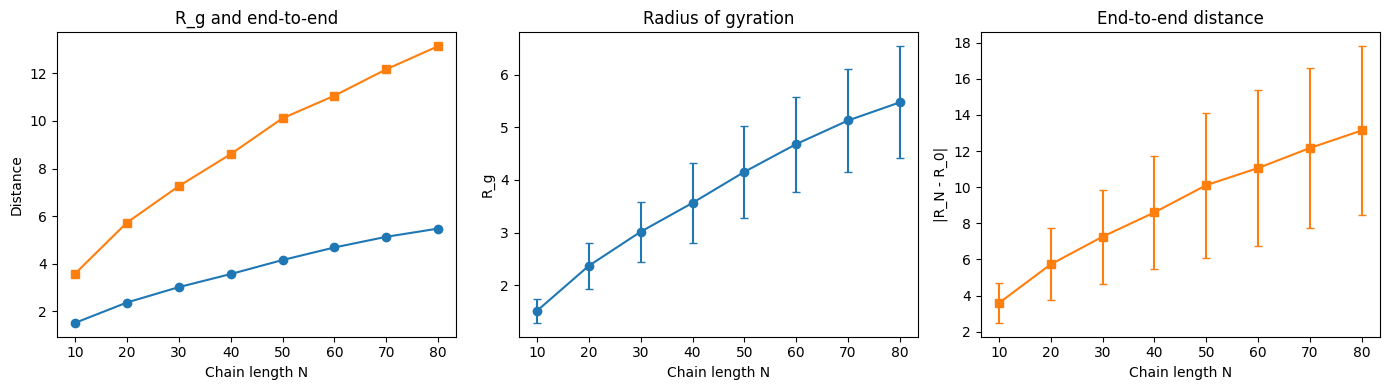

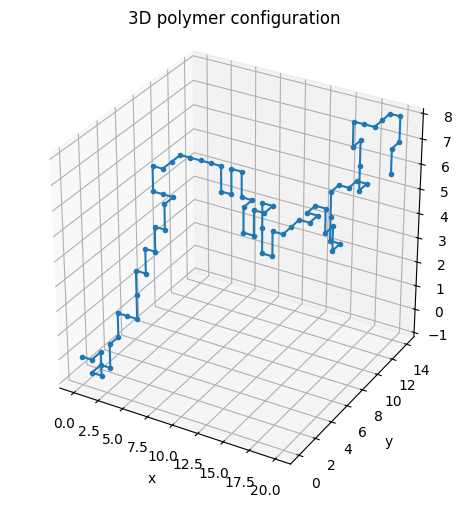

In [5]:
tm_mc.plot_results(tm_results, show=True, save_path="")

tm_rng = np.random.default_rng(1)
tm_snapshot_samples = tm_mc.metropolis_sample_saw(
    tm_chain_lengths[-1],
    tm_rng,
    n_steps=4000,
    burn_in=1000,
    thin=200,
    max_restarts=2000,
)
if tm_snapshot_samples:
    tm_mc.plot_polymer_3d(tm_snapshot_samples[-1], show=True, save_path="")


In [20]:
gs_chain_lengths = list(range(10, 81, 10))
gs_results = gs_mc.run_simulation(
    chain_lengths=gs_chain_lengths,
    n_chains=200,
    seed=1,
    max_restarts=2000,
)

gs_df = pd.DataFrame(gs_results)
gs_df


,N,rg_mean,rg_std,e2e_mean,e2e_std
0,10,1.521507,0.253255,3.623418,1.228163
1,20,2.201482,0.418631,5.068342,1.977743
2,30,2.821846,0.584490,6.891369,2.555717
3,40,3.258705,0.702999,7.701275,2.917692
4,50,3.600421,0.733151,8.217707,3.289894
5,60,4.066539,0.925063,9.795811,3.944602
6,70,4.339220,0.972343,9.959154,3.988078
7,80,4.575806,0.892132,10.386862,4.299480


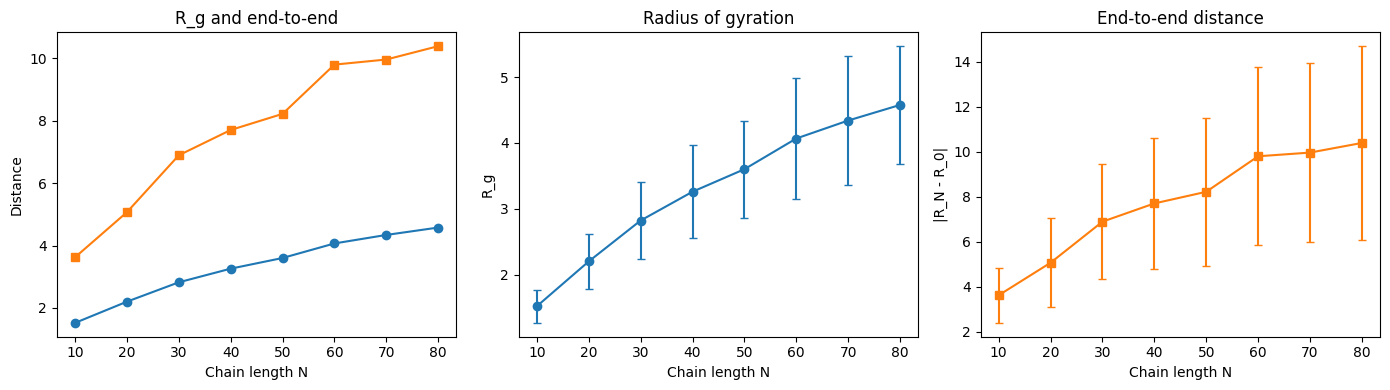

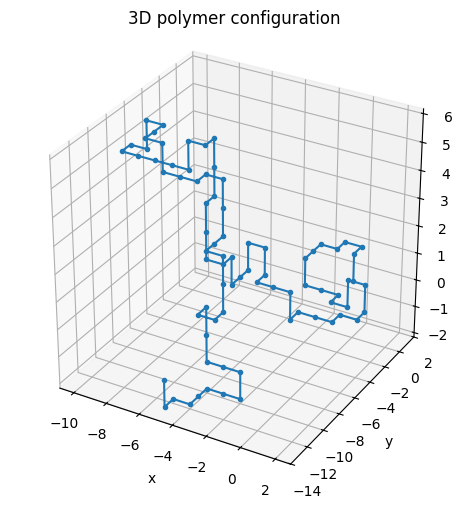

In [21]:
gs_mc.plot_results(gs_results, show=True, save_path="")

gs_rng = np.random.default_rng(1)
gs_positions = gs_mc.generate_self_avoiding_walk(
    gs_chain_lengths[-1], gs_rng, max_restarts=2000
)
gs_mc.plot_polymer_3d(gs_positions, show=True, save_path="")


# Analysis

## 1. Running multiple replicates for both methods (different seeds)

In [ ]:
chain_lengths = list(range(10, 81, 10))
n_reps = 20  # 10–30 is reasonable

# ---- Metropolis reps ----
tm_reps = []
for rep in range(n_reps):
    tm_results = tm_mc.run_metropolis_simulation(
        chain_lengths=chain_lengths,
        n_samples_per_n=200,
        seed=rep,          # deterministic per replicate
        n_steps=12000,
        burn_in=3000,
        thin=40,
        max_restarts=2000,
    )
    df = pd.DataFrame(tm_results)
    df["rep"] = rep
    df["method"] = "TM"
    tm_reps.append(df)

tm_long = pd.concat(tm_reps, ignore_index=True)
print("tm_reps done")

# ---- Growth-sampling reps ----
gs_reps = []
for rep in range(n_reps):
    gs_results = gs_mc.run_simulation(
        chain_lengths=chain_lengths,
        n_chains=200,
        seed=rep,          # deterministic per replicate
        max_restarts=2000,
    )
    df = pd.DataFrame(gs_results)
    df["rep"] = rep
    df["method"] = "GS"
    gs_reps.append(df)

gs_long = pd.concat(gs_reps, ignore_index=True)
print("gs_reps done")

long = pd.concat([tm_long, gs_long], ignore_index=True)
print("df done")

tm_reps done
gs_reps done
df done


In [34]:
long.head()

,N,rg_mean,rg_std,e2e_mean,e2e_std,rep,method
0,10,1.551277,0.243386,3.700578,1.209560,0,TM
1,20,2.380200,0.413830,5.800083,1.880616,0,TM
2,30,3.020613,0.599710,7.376434,2.710157,0,TM
3,40,3.667727,0.664979,8.713366,3.108952,0,TM
4,50,4.075497,0.755533,9.925897,3.552417,0,TM


### Quick Check: Do they agree within variability

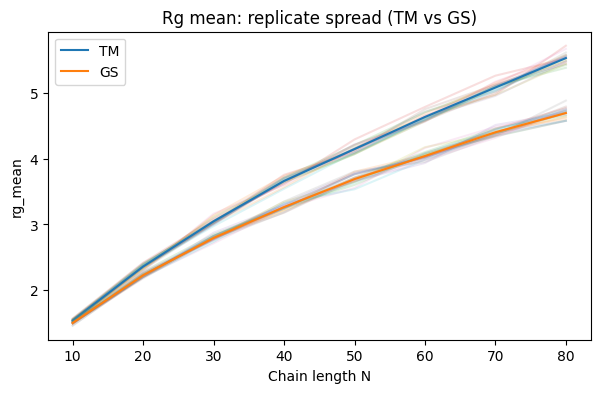

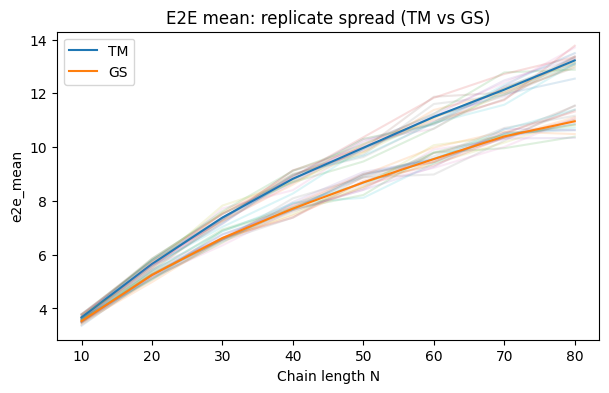

In [23]:
def plot_with_replicate_spread(long, ycol, title):
    fig, ax = plt.subplots(figsize=(7,4))
    for method in ["TM", "GS"]:
        sub = long[long["method"] == method]
        # replicate curves (faint)
        for rep, g in sub.groupby("rep"):
            ax.plot(g["N"], g[ycol], alpha=0.15)
        # mean curve (bold-ish)
        mean_curve = sub.groupby("N")[ycol].mean().reset_index()
        ax.plot(mean_curve["N"], mean_curve[ycol], label=method)
    ax.set_title(title)
    ax.set_xlabel("Chain length N")
    ax.set_ylabel(ycol)
    ax.legend()
    plt.show()

plot_with_replicate_spread(long, "rg_mean", "Rg mean: replicate spread (TM vs GS)")
plot_with_replicate_spread(long, "e2e_mean", "E2E mean: replicate spread (TM vs GS)")


## 2. Method difference per N (paired by replicate seed)

In [24]:
# Pivot to compare TM vs GS per (rep, N)
tm_p = tm_long[["rep","N","rg_mean","e2e_mean"]].rename(columns={"rg_mean":"tm_rg", "e2e_mean":"tm_e2e"})
gs_p = gs_long[["rep","N","rg_mean","e2e_mean"]].rename(columns={"rg_mean":"gs_rg", "e2e_mean":"gs_e2e"})

paired = tm_p.merge(gs_p, on=["rep","N"], how="inner")
paired["d_rg"]  = paired["gs_rg"]  - paired["tm_rg"]
paired["d_e2e"] = paired["gs_e2e"] - paired["tm_e2e"]

paired.head()

,rep,N,tm_rg,tm_e2e,gs_rg,gs_e2e,d_rg,d_e2e
0,0,10,1.551277,3.700578,1.469124,3.396451,-0.082153,-0.304127
1,0,20,2.380200,5.800083,2.200095,5.117107,-0.180105,-0.682977
2,0,30,3.020613,7.376434,2.785873,6.444260,-0.234740,-0.932174
3,0,40,3.667727,8.713366,3.233452,7.784265,-0.434275,-0.929100
4,0,50,4.075497,9.925897,3.800871,8.964762,-0.274626,-0.961136


### Plot the differences

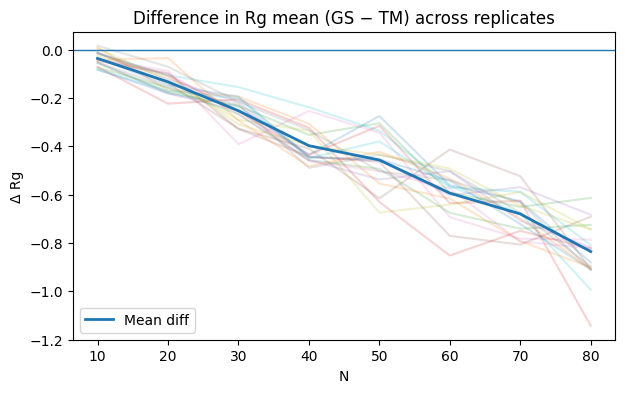

In [25]:
fig, ax = plt.subplots(figsize=(7,4))
for rep, g in paired.groupby("rep"):
    ax.plot(g["N"], g["d_rg"], alpha=0.2)
mean_diff = paired.groupby("N")["d_rg"].mean().reset_index()
ax.plot(mean_diff["N"], mean_diff["d_rg"], label="Mean diff", linewidth=2)
ax.axhline(0, linewidth=1)
ax.set_title("Difference in Rg mean (GS − TM) across replicates")
ax.set_xlabel("N")
ax.set_ylabel("Δ Rg")
ax.legend()
plt.show()


### Interpretation of the Mean Difference in Radius of Gyration Across Replicates

The plot shows the difference in the mean radius of gyration, \(\Delta R_g = R_g^{\mathrm{GS}} - R_g^{\mathrm{TM}}\), as a function of chain length \(N\) across multiple independent replicates. Individual replicate trajectories are shown as faint lines, while the bold line represents the average difference over all replicates.

For all values of \(N\), \(\Delta R_g\) remains negative, indicating that growth sampling systematically underestimates the radius of gyration relative to Metropolis Monte Carlo. The absence of any crossings of the zero line across replicates confirms that this discrepancy is not due to stochastic variability.

Moreover, the magnitude of the negative difference increases approximately monotonically with increasing \(N\). This trend demonstrates that the bias introduced by growth sampling accumulates with chain length, consistent with a growth-induced distortion of the polymer conformational ensemble.

The relatively small spread between replicate trajectories compared to the overall downward trend indicates that the observed behaviour is robust and reproducible. Variations between replicates are minor compared to the systematic shift, reinforcing the conclusion that the difference arises from algorithmic bias rather than finite-sample noise.


## 3. Bootstrap confidence intervals for the mean difference (per N)

In [26]:
def bootstrap_ci(x, n_boot=5000, ci=95, seed=0):
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    boots = []
    for _ in range(n_boot):
        sample = rng.choice(x, size=len(x), replace=True)
        boots.append(sample.mean())
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100 - (100-ci)/2)
    return float(x.mean()), float(lo), float(hi)

rows = []
for N, g in paired.groupby("N"):
    m, lo, hi = bootstrap_ci(g["d_rg"].values, seed=1)
    rows.append({"N": N, "metric": "ΔRg (GS−TM)", "mean": m, "ci_lo": lo, "ci_hi": hi})
    m, lo, hi = bootstrap_ci(g["d_e2e"].values, seed=2)
    rows.append({"N": N, "metric": "ΔE2E (GS−TM)", "mean": m, "ci_lo": lo, "ci_hi": hi})

ci_df = pd.DataFrame(rows)
ci_df

,N,metric,mean,ci_lo,ci_hi
0,10,ΔRg (GS−TM),-0.036019,-0.048443,-0.023168
1,10,ΔE2E (GS−TM),-0.135200,-0.196132,-0.070504
2,20,ΔRg (GS−TM),-0.133029,-0.152165,-0.113754
3,20,ΔE2E (GS−TM),-0.411650,-0.489181,-0.335112
4,30,ΔRg (GS−TM),-0.252686,-0.277945,-0.229368
5,30,ΔE2E (GS−TM),-0.763595,-0.855387,-0.670099
6,40,ΔRg (GS−TM),-0.397308,-0.428316,-0.364584
7,40,ΔE2E (GS−TM),-1.109683,-1.252436,-0.963518
8,50,ΔRg (GS−TM),-0.456502,-0.504911,-0.408876
9,50,ΔE2E (GS−TM),-1.289988,-1.483522,-1.099948


### Interpretation of Bootstrap Confidence Intervals

The bootstrap confidence intervals provide information beyond the previously observed mean trends and scaling exponents.

First, for every chain length \(N\), the 95% confidence intervals for the mean differences \(\Delta R_g = R_g^{\mathrm{GS}} - R_g^{\mathrm{TM}}\) and \(\Delta R_{ee} = R_{ee}^{\mathrm{GS}} - R_{ee}^{\mathrm{TM}}\) lie entirely below zero. This demonstrates that the discrepancies between growth sampling and Metropolis Monte Carlo are **statistically decisive**, ruling out the possibility that the observed differences arise from finite-sample noise.

Second, the magnitude of the negative mean differences increases monotonically with \(N\). This shows that the bias introduced by growth sampling is **not constant**, but instead **accumulates with chain length**, which is characteristic of a growth-induced attrition bias affecting asymptotic polymer behaviour.

Third, the widths of the confidence intervals remain relatively narrow as \(N\) increases. This indicates that the growing discrepancy is **not driven by increasing statistical uncertainty** at larger chain lengths, but reflects a genuine, systematic distortion of the sampled conformational ensemble.

Finally, the absolute magnitude of \(\Delta R_{ee}\) is consistently larger than that of \(\Delta R_g\), indicating that the end-to-end distance is a more sensitive diagnostic of the growth-sampling bias than the radius of gyration. This suggests that growth sampling preferentially suppresses long-range chain extension rather than uniformly rescaling overall polymer size.


## 4. Scaling exponent comparison (fit $\nu$ from $\langle R_g \rangle \sim N^{\nu}$)

$$
\log \langle R_g \rangle = \log A + \nu \log N
$$


In [27]:
def fit_nu(df, ycol):
    # linear regression on log-log: log y = a + nu log N
    x = np.log(df["N"].values.astype(float))
    y = np.log(df[ycol].values.astype(float))
    nu, a = np.polyfit(x, y, 1)
    return float(nu), float(a)

# Fit nu per replicate for each method
nu_rows = []
for method, sub in long.groupby("method"):
    for rep, g in sub.groupby("rep"):
        nu_rg, _ = fit_nu(g, "rg_mean")
        nu_e2e, _ = fit_nu(g, "e2e_mean")
        nu_rows.append({"method": method, "rep": rep, "nu_rg": nu_rg, "nu_e2e": nu_e2e})

nu_df = pd.DataFrame(nu_rows)
nu_df.groupby("method")[["nu_rg","nu_e2e"]].agg(["mean","std"])

nu_rg              nu_e2e          
            mean       std      mean       std
method                                        
GS      0.547993  0.007928  0.548219  0.016803
TM      0.614100  0.006626  0.615626  0.013048

### Plot the difference

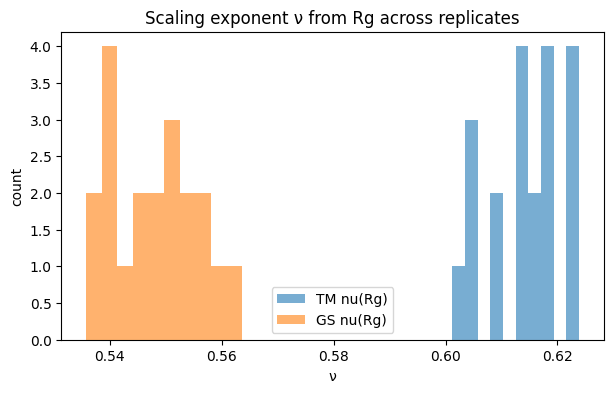

In [28]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(nu_df[nu_df["method"]=="TM"]["nu_rg"], alpha=0.6, label="TM nu(Rg)")
ax.hist(nu_df[nu_df["method"]=="GS"]["nu_rg"], alpha=0.6, label="GS nu(Rg)")
ax.set_title("Scaling exponent ν from Rg across replicates")
ax.set_xlabel("ν")
ax.set_ylabel("count")
ax.legend()
plt.show()


For each replicate, the scaling exponent $\nu$ was obtained by fitting $\langle R_g \rangle \sim N^{\nu}$ on log–log axes. 

The resulting distributions of fitted exponents are shown. Growth sampling consistently yields smaller $\nu$ values than Metropolis Monte Carlo, indicating a systematic bias in the sampled conformational ensemble.”

The systematically smaller scaling exponent $\nu$ obtained from growth sampling indicates a bias toward more compact polymer conformations. Since $\nu$ characterises the global swelling behaviour of the chain, a consistent downward shift across replicates reflects a distortion of the equilibrium conformational ensemble rather than statistical noise. This bias originates from the growth-based construction, where early local choices constrain future configurations and trapped chains are discarded, leading to unequal sampling of self-avoiding walks. In contrast, Metropolis Monte Carlo samples complete configurations with correct equilibrium weights, yielding a larger and more accurate $\nu$.

A smaller $\nu$ is a sign of systematic bias because it means the algorithm consistently produces polymers that are too compact compared to the true equilibrium ensemble.

In [ ]:
### Using Gaussian KDE to estimate distributions of ν values
from scipy.stats import gaussian_kde

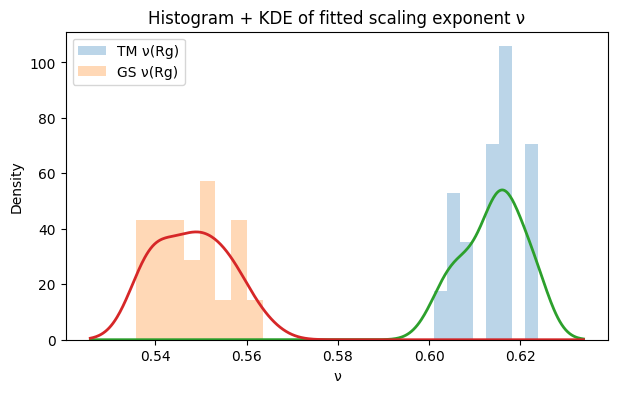

In [33]:
tm_vals = nu_df[nu_df["method"]=="TM"]["nu_rg"].values
gs_vals = nu_df[nu_df["method"]=="GS"]["nu_rg"].values

x = np.linspace(
    min(tm_vals.min(), gs_vals.min()) - 0.01,
    max(tm_vals.max(), gs_vals.max()) + 0.01,
    500
)

tm_kde = gaussian_kde(tm_vals)
gs_kde = gaussian_kde(gs_vals)

fig, ax = plt.subplots(figsize=(7,4))

ax.hist(tm_vals, bins=8, density=True, alpha=0.3, label="TM ν(Rg)")
ax.hist(gs_vals, bins=8, density=True, alpha=0.3, label="GS ν(Rg)")

ax.plot(x, tm_kde(x), linewidth=2)
ax.plot(x, gs_kde(x), linewidth=2)

ax.set_xlabel("ν")
ax.set_ylabel("Density")
ax.set_title("Histogram + KDE of fitted scaling exponent ν")
ax.legend()

plt.show()


Kernel density estimates corroborate the histogram-based comparison, showing two well-separated, unimodal distributions of fitted scaling exponents. The absence of significant overlap confirms that the observed difference between GS and TM is systematic rather than an artefact of binning or statistical noise.

### Quick check: Universal ratio proxy (quick “shape sanity”)

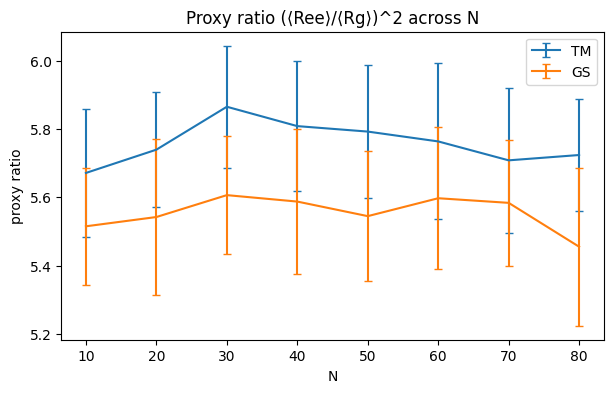

In [36]:
# Note: "universal ratio" is usually <Ree^2>/<Rg^2>; here we only have means.
# We'll use a proxy: (mean Ree / mean Rg)^2.
summary = long.copy()
summary["ratio_proxy"] = (summary["e2e_mean"] / summary["rg_mean"])**2

fig, ax = plt.subplots(figsize=(7,4))
for method in ["TM", "GS"]:
    sub = summary[summary["method"]==method]
    m = sub.groupby("N")["ratio_proxy"].mean().reset_index()
    s = sub.groupby("N")["ratio_proxy"].std().reset_index()
    ax.errorbar(m["N"], m["ratio_proxy"], yerr=s["ratio_proxy"], capsize=3, label=method)
ax.set_title("Proxy ratio (⟨Ree⟩/⟨Rg⟩)^2 across N")
ax.set_xlabel("N")
ax.set_ylabel("proxy ratio")
ax.legend()
plt.show()